<a href="https://colab.research.google.com/github/BenUCL/AI4Reefs-Workshop/blob/main/Nueral_Networks_%26_Images_Answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Nets for Image Data**

In this final notebook, we're going to replicate a task set in a hackathon earlier this year. [Read the full blog post here](https://www.buildingcoral.com/news/mars-data-scientists-turn-their-skills-to-coral-reef-restoration) (2min read).

We will train a classifier to identify images from healthy and degraded reefs. We will once again start by doing this with transfer learning. We will then train the network from scratch, updating all the layers in the network.

The approach we are taking is a good start, but it won't be perfect. You'll want to stay alert to some of the issues we see in the results and think about causes and fixes.


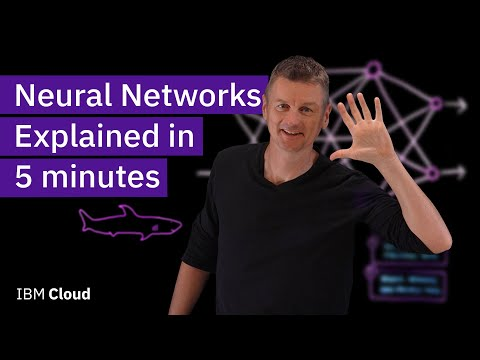

In [ ]:
#@title If you haven't already, watch this explainer on how neural networks work
from IPython.display import YouTubeVideo

# YouTube video ID
video_id = "jmmW0F0biz0"

# Display the YouTube video in the notebook
YouTubeVideo(video_id)

## Access the new data

We should have added a shortcut link to your own drive for the dataset folder in the intro colab, make sure to do this if you haven't already.

First up, take a look at the data on your drive. We have two formats, the raw unprocessed data in 'mars_hackathon' and the preprocessed data in 'mars_hackathon_preprocessed'. Each sub-folder represents an individual site (keep this in mind!). A good model should be able to generalise to new sites and remain accurate.

Questions:
1. What has the preprocessing done to the data? What do you think the purpose of this is?
A: resized, this is because the raw images are too high res to go into the network.
2. We are going to train a model to classify images as 'healthy' and 'degraded'. Take a look at some of the different folders. Does the task look achievable? What issues could we face with generalisability to new data not included here?
A: yes. generic stuff like diff types of coral, colour of images, survey method used





## Now we are ready to start running some code

Add in the appropriate file paths below and make sure to connect to a GPU runtime.

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the unprocessed images
image_dir = '/content/drive/MyDrive/RCUK_AI_Workshop/mars_hackathon_filtered/mars_hackathon'

# Path to our preprocessed image data
preprocessed_dir = '/content/drive/MyDrive/RCUK_AI_Workshop/mars_hackathon_filtered/mars_hackathon_resized'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Imports and settings
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random

# Set the seed for numpy, random, and TensorFlow at the beginning of your script
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

# Number of epochs
num_epochs = 5
batch_size =  32

Questions
1. What is an epoch when training a neural network?
A: the network has seen every data sample once
2. What is batch size?
A: Number of samples the network uses to update its weights at each iteration

### Loading data

Note this is the largest part of the code (even with the preprocessing done for you!). This is often where most of the work is actually done in an ML project.

In [ ]:
# Function to create a df of the data filepaths so we can access and split it
def create_dataframe(folder_path, label):
    filepaths = []
    labels = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(root, file))
                labels.append(label)
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

# Paths to the main class directories
healthy_dir = os.path.join(preprocessed_dir, 'healthy')
degraded_dir = os.path.join(preprocessed_dir, 'degraded')

# Create dataframes
df_healthy = create_dataframe(healthy_dir, 'healthy')
df_degraded = create_dataframe(degraded_dir, 'degraded')

# Combine dataframes
df = pd.concat([df_healthy, df_degraded], ignore_index=True)

# Splitting the dataframe into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=0, stratify=df['label'])

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),  # Assuming you're still working with MobileNetV2
    class_mode='binary',
    batch_size=batch_size)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=batch_size)

# This will print the train and val dataset sizes

Found 349 validated image filenames belonging to 2 classes.
Found 88 validated image filenames belonging to 2 classes.


## Now train our model!

We start by performing transfer learning using the 'MobileNetV2' pretrained neural network. This is a small network so it runs fast.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os

# Load pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# We will add 1 output neuron, as we are performing a binary classification task
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze every layer except our final output neuron
for layer in base_model.layers:
    layer.trainable = False

# Final settings for the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model!
model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/5
11/11 [==============================] - 88s 7s/step - loss: 0.9341 - accuracy: 0.6705 - val_loss: 0.3470 - val_accuracy: 0.8182
Epoch 2/5
11/11 [==============================] - 2s 147ms/step - loss: 0.3311 - accuracy: 0.8825 - val_loss: 0.2899 - val_accuracy: 0.8750
Epoch 3/5
11/11 [==============================] - 2s 157ms/step - loss: 0.1928 - accuracy: 0.9226 - val_loss: 0.3599 - val_accuracy: 0.8977
Epoch 4/5
11/11 [==============================] - 2s 174ms/step - loss: 0.1411 - accuracy: 0.9427 - val_loss: 0.2509 - val_accuracy: 0.9091
Epoch 5/5
11/11 [==============================] - 2s 133ms/step - loss: 0.0925 - accuracy: 0.9799 - val_loss: 0.2405 - val_accuracy: 0.9091


## Questions/Exercises
Take your time to understand a bit more about the output and what we have done here.

You can start by running the cell below to look at some example predictions from the validation set. Can you see why some may be incorrect or have different confidence scores?

Now try these questions:

1. What do you notice about how the train accuracy and the validation accuracy are changing. Do these differ, and if so why?
A: train acc likely higher and increases mostly steadily. Val acc may be lower and increase more randomly. The network is fitting to the train data so is optimised to this.
2. Which of these two measures should we focus on?
A: Val acc
3. Here, we have randomly selected 80% of the data from all sites as training data. What would be a better way to split this?
A: We should take a whole site or two from each class as val data
4. How can we now select the best version of the model for new data going forward?
A: Find the epoch with the highest val acc. Train this num of epochs.
5. If we want a final publishable accuracy, what else do we need to do?
A: Create a third data split; a test set.

Further Experiments:
6. Try increasing or decreasing the num_epochs. What does this do to the accuracies and their relationships? Keep notes on the best epoch.
A: dependant on students working
7. Which small part of the code can we change to train the full network, so we're not transfer learning, but training the whole network? Try it!
A: change  layer.trainable to True
8. Which is better? Why could this be?
A: Important to look at val acc here. May be transfer learning in this case, as our dataset is small. May be fully trained network if it hasn't overtrained.
9. Now lets train the best version of our model from what you've tried. What information from the results so far can we use to do this?
A: Of the above combinations

Finally - what could we start using this model for and where? What would happen if we changed how we collected are data or where this was from? What limitations should we keep in mind.

In [ ]:
#@title View images
import matplotlib.pyplot as plt
import numpy as np

def display_images_with_predictions(generator, model, start_img=0, end_img=10):
    """
    Display images from the generator along with model's predictions and confidence scores.
    """
    batch_size = generator.batch_size
    images_shown = 0
    total_images = start_img + (end_img - start_img)

    while images_shown < total_images:
        data = next(generator)
        images, labels = data[0], data[1]

        for i in range(len(images)):
            current_img_index = images_shown + batch_size * generator.batch_index
            if current_img_index >= start_img and current_img_index < end_img:
                plt.imshow(images[i])
                plt.axis('off')

                # Predict the class and probability of the image
                prediction = model.predict(np.expand_dims(images[i], axis=0))
                predicted_label = 'degraded' if prediction[0][0] < 0.5 else 'healthy'
                confidence = prediction[0][0] if predicted_label == 'healthy' else 1 - prediction[0][0]
                true_label = 'degraded' if labels[i] < 0.5 else 'healthy'

                plt.title(f'Predicted: {predicted_label} ({confidence:.2f}), True: {true_label}')
                plt.show()

            images_shown += 1

            if images_shown == total_images:
                return

# Adjust these to view different images
start_img=1
end_img=10

# Now display results
display_images_with_predictions(validation_generator, model, start_img=start_img, end_img=end_img)

# We see the predicted class, the models confidence in this and the True class.